In [1]:
import pandas as pd
import joey_utils as ut
import os
import numpy as np
from matplotlib import *
import matplotlib

# Transfer importance to csv

In [2]:
def importance_sort(filename, mode='accuracy'):
    fp = open(os.path.join(filename),"r")
    gp = open(os.path.join(filename[:-3] + 'out'), 'r') #.err
    accs = []
    num_node = 0
    # record original accuracy and data name
    for line in gp:
        if line[0:4] == 'data':
            data = '_'.join(line.strip().split(':')[1].split('_')[0:2])
        if line[0:8] == "Original":
            original_acc = float(line[line.index("(") + 1:].split(",")[0])
            break
            
    for line in fp:
        if line[0:4] == "Node" or line[0:4] == "Edge":
            accs.append(float(line.strip().split(" ")[-1]))
            if line[0:4] == "Node":
                num_node += 1
    assert mode == 'error' or 'accuracy'
    if mode == 'accuracy':
        print(original_acc)
        tmp = [(original_acc - x) / original_acc for x in accs]
        normalized = [y/np.sum(tmp) for y in tmp]
    elif mode == 'error':
        tmp = [(x - original_acc)/ (1 - original_acc) for x in accs]
        normalized = [y/np.sum(tmp) for y in tmp]
    edge_ind = []
    for ind in range(1,num_node+1):
        k = ind + 1
        while k < num_node+1:
            edge_ind.append((ind,k))
            k += 1
    if data.find('HCV') != -1:
#     nodes = [198,199,200,201,202,58,70,72,73,96,138,147,150,151,152,154,170,171,172,173,174,175,176,177,178,179,180,181,182,183,197,203,204,205]
        nodes = ['P6','P5','P4','P3','P2',58,70,72,73,96,138,147,150,151,152,154,170,171,172,173,174,175,176,177,178,179,180,181,182,183,"P7","P1","P1'","P2'"]
    elif data.find('TEV') != -1:
        nodes = ['P6','P5','P4','P3','P2',30,32,44,45,46,47,49,81,134,139,148,149,151,152,167,168,169,170,171,172,173,174,175,176,177,178,208,209,211,213,214,215,216,217,218,219,220,221,'P7', 'P1', "P1'", "P2'"]

    df = pd.DataFrame(normalized, index=range(len(normalized)))
    new_index = []
    for i in range(1,num_node+1):
        new_index.append(str(nodes[i-1]))
    for j in range(1,len(accs) - num_node + 1):
        pair = edge_ind[j-1]
        new_index.append(' '.join([str(nodes[pair[0]-1]), str(nodes[pair[1]-1])]))
    df.index = new_index
    df_sort = df.sort_values(by=0, ascending=True)
    return df, data

In [52]:
# filenames = ['varimport.HCV_WT.aa.slepner009.20965737.err', 
#              'varimport.HCV_A171T.aa.slepner009.20965738.err', 
#              'varimport.HCV_D183A.aa.slepner058.20965739.err', 
#              'varimport.HCV_Combined.aa.slepner075.20965741.err', 
#              'varimport.TEV_Combined.aa.hal0032.20965742.err']
features = ['complete','seq','energy']
i = 0
for feature in features:
    for file in os.listdir(os.path.join('../PGCN/VariableImportance/', feature)):
        if file.split('.')[-1] == 'err':
            df_tmp,name = importance_sort('../PGCN/VariableImportance/' + os.path.join(feature, file))
            newname = '_'.join([name.strip(), 'binary', feature])
            df_tmp.rename(columns = {0:newname},inplace=True)
            if i == 0:
                df = df_tmp
                i = 1
            else:
                df = pd.concat([df,df_tmp],axis=1)
# oris = [0.9211, 0.9637, 0.8989, 0.9357, 0.9225, 0.8785]
# for i,name in enumerate(filenames):
#     df_tmp,tmp_df = importance_sort(name, oris[i])
    #if name.split('.')[1] != 'binaryall':
    #    upper_index = np.where([x.isupper() for x in name.split('.')[1]])[0][0]
    #else:
    #    upper_index = 6
    #newname = '_'.join([name.split('.')[1][upper_index:], name.split('.')[1][0:upper_index], name.split('.')[2]])
    # newname = name.split('.')[1]
    # df_tmp.rename(columns = {0:newname},inplace=True)
# df.to_csv("variable_importance_binary_hcv_tev_20220721.csv")

0.8785
0.9211
0.9637
0.8989
0.9357
0.9225
0.8692
0.9184
0.9652
0.8989
0.9371
0.9236
0.9007
0.9584
0.9103
0.8656
0.8905
0.9254


In [53]:
df.to_csv("tables/variable_importance_binary_hcv_tev_20220721.csv")

# variable importance analysis

In [3]:
def label_feature_type(row):
    if ' ' in row['Feature']:
        return 'edge'
    else:
        return 'node'

In [4]:
def label_feature_location(row):
    if row['Type'] == 'node':
        if 'P' in row['Feature']:
            return 'peptide'
        else:
            return 'protease'
    else:
        ends = row['Feature'].split()
        are_subs = ['P' in i for i in ends]
        if all(are_subs):
            return 'peptide'
        elif not any(are_subs):
            return 'protease'
        else:
            return 'intermolecular'        

In [8]:
substrate_order = {"P7": -9, "P6": -8, "P5": -7, "P4": -6, 
    "P3": -5, "P2": -4, "P1": -3, "P1'": -2, "P2'": -1}

In [5]:
def feat_id(row, col):
    if row['Type'] == 'node':
        x = [ut.str2int(row['Feature']), None]
    else:
        if row['Location'] == 'protease':
            f = [int(i) for i in row['Feature'].split()]
            x = [min(f), max(f)]
        elif row['Location'] == 'peptide':
            so = list(substrate_order)
            f = [so.index(i) for i in row['Feature'].split()]
            x = [so[min(f)], so[max(f)]]
        else:
            f = [ut.str2int(i) for i in row['Feature'].split()]
            x = [i for i in f if i in substrate_order] + [i for i in f if i not in substrate_order]
            
    return x[col]

In [6]:
def give_ord(row, col):
    assert col in [1, 2]
    if col == 1:
        if row['Location'] in ['peptide', 'intermolecular']:
            return substrate_order[row['F1']]
        else:
            return row['F1']
    else:
        if isinstance(row['F2'], str):
            return substrate_order[row['F2']]
        elif isinstance(row['F2'], int):
            return row['F2']
        else:
            return 0

In [29]:
# df = pd.read_csv('/mnt/d/PGCN/tables+combined_data_new_combined_data.csv')
df = pd.read_csv('tables/variable_importance_binary_hcv_tev_20220721.csv')
#df = pd.read_csv('../outputs/variable_importance_binary_tev_20220610_final.csv')
df = df.rename(columns = {'Unnamed: 0' : 'Feature'})
df.head()

,Feature,TEV_all_binary_complete,HCV_WT_binary_complete,HCV_A171T_binary_complete,HCV_D183A_binary_complete,HCV_Triple_binary_complete,HCV_all_binary_complete,TEV_all_binary_seq,HCV_WT_binary_seq,HCV_A171T_binary_seq,HCV_D183A_binary_seq,HCV_Triple_binary_seq,HCV_all_binary_seq,HCV_WT_binary_energy,HCV_A171T_binary_energy,HCV_all_binary_energy,TEV_all_binary_energy,HCV_D183A_binary_energy,HCV_Triple_binary_energy
0,P6,0.080836,0.028354,0.034950,0.001927,0.064895,0.032599,0.228729,0.049850,0.063096,0.016265,0.018296,0.038212,0.011147,0.034221,0.017630,0.073435,0.031498,0.057913
1,P5,0.056571,0.089557,0.086156,0.075163,0.103654,0.095271,0.066022,0.086075,0.090797,0.065712,0.120802,0.083417,0.140566,0.052281,0.076590,0.077417,0.023065,0.057913
2,P4,0.129221,0.188105,0.133297,0.273910,0.129568,0.176997,0.213536,0.271519,0.181902,0.375407,0.150125,0.175824,0.222132,0.109791,0.136127,0.065251,0.154762,0.113109
3,P3,0.086245,0.437414,0.500406,0.349073,0.411296,0.397612,0.106630,0.416085,0.517390,0.419323,0.538596,0.399101,0.203371,0.453422,0.385838,0.057067,0.177579,0.348317
4,P2,0.067388,0.197787,0.121105,0.109612,0.132890,0.091139,0.111878,0.176471,0.146814,0.123292,0.172180,0.124126,0.151713,0.043251,0.044798,0.097766,0.102431,0.134434


In [30]:
df['Type'] = df.apply(lambda row: label_feature_type(row), axis='columns')
df['Location'] = df.apply(lambda row: label_feature_location(row), axis='columns')
df['F1'] = df.apply(lambda row: feat_id(row, 0), axis='columns')
df['F2'] = df.apply(lambda row: feat_id(row, 1), axis='columns')

In [31]:
df.shape

(1513, 23)

In [32]:
# sum_cols = {'WT_binary_all': 'sum', 'WT_binary_energy': 'sum',
#     'A171T_binary_all': 'sum', 'A171T_binary_energy': 'sum',
#     'D183A_binary_all': 'sum', 'D183A_binary_energy': 'sum',
#     'Triple_binary_all': 'sum', 'Triple_binary_energy': 'sum',
#     'all_binary_all': 'sum', 'all_binary_energy': 'sum'}
sum_cols = {u:'sum' for u in ['TEV_all_binary_complete', 'HCV_all_binary_complete', 'HCV_WT_binary_complete', 'HCV_A171T_binary_complete', 'HCV_D183A_binary_complete', 'HCV_Triple_binary_complete', 
        'TEV_all_binary_energy', 'HCV_all_binary_energy', 'HCV_WT_binary_energy', 'HCV_A171T_binary_energy', 'HCV_D183A_binary_energy', 'HCV_Triple_binary_energy', 
        'TEV_all_binary_seq', 'HCV_all_binary_seq', 'HCV_WT_binary_seq', 'HCV_A171T_binary_seq', 'HCV_D183A_binary_seq', 'HCV_Triple_binary_seq']}
#'WT_ternary_all': 'sum', 'WT_ternary_energy': 'sum',
#     'A171T_ternary_all': 'sum', 'A171T_ternary_energy': 'sum',
#     'D183A_ternary_all': 'sum', 'D183A_ternary_energy': 'sum',
#     'Triple_ternary_all': 'sum', 'Triple_ternary_energy': 'sum',
#sum_cols = {'TEV_binary_all': 'sum', 'TEV_binary_energy': 'sum'}
edge_sums = pd.DataFrame([])
nodes = df[df['Type'] == 'node']['F1'].unique()
for node in nodes:
    subdf = df[(df['F1'] == node) & (df['F2'].isnull())].append(df[df['F2'] == node])
    subdf = subdf[list(sum_cols)]
    aggregated = subdf.aggregate(sum_cols)
    aggregated['Feature'] = node
    aggregated['F1'] = node
    aggregated['F2'] = None
    aggregated['Type'] = 'edge sum'
    if isinstance(node, str):
        aggregated['Location'] = 'peptide'
    else:
        aggregated['Location'] = 'protease'
    edge_sums = edge_sums.append(aggregated, ignore_index=True)
df = df.append(edge_sums, ignore_index=True)

In [38]:
df.columns

Index(['Feature', 'TEV_all_binary_complete', 'HCV_WT_binary_complete',
       'HCV_A171T_binary_complete', 'HCV_D183A_binary_complete',
       'HCV_Triple_binary_complete', 'HCV_all_binary_complete',
       'TEV_all_binary_seq', 'HCV_WT_binary_seq', 'HCV_A171T_binary_seq',
       'HCV_D183A_binary_seq', 'HCV_Triple_binary_seq', 'HCV_all_binary_seq',
       'HCV_WT_binary_energy', 'HCV_A171T_binary_energy',
       'HCV_all_binary_energy', 'TEV_all_binary_energy',
       'HCV_D183A_binary_energy', 'HCV_Triple_binary_energy', 'Type',
       'Location', 'F1', 'F2'],
      dtype='object')

In [39]:
df['O1'] = df.apply(lambda row: give_ord(row, 1), axis='columns')
df['O2'] = df.apply(lambda row: give_ord(row, 2), axis='columns')
df = df.sort_values(['Type', 'Location', 'O1', 'O2'], ascending=[False, True, True, True])
df = df.reset_index(drop=True)
# cols = ['Feature', 'F1', 'F2', 'Type', 'Location',
#         'TEV_binary_all', 'TEV_binary_energy']
cols = ['Feature', 'F1', 'F2', 'Type', 'Location', 'TEV_all_binary_complete',
    'HCV_all_binary_complete', 'HCV_WT_binary_complete', 'HCV_A171T_binary_complete', 'HCV_D183A_binary_complete', 'HCV_Triple_binary_complete', 
        'TEV_all_binary_energy', 'HCV_all_binary_energy', 'HCV_WT_binary_energy', 'HCV_A171T_binary_energy', 'HCV_D183A_binary_energy', 'HCV_Triple_binary_energy', 
        'TEV_all_binary_seq', 'HCV_all_binary_seq', 'HCV_WT_binary_seq', 'HCV_A171T_binary_seq', 'HCV_D183A_binary_seq', 'HCV_Triple_binary_seq'
       ]
# 'WT_ternary_all', 'A171T_ternary_all', 'D183A_ternary_all', 'Triple_ternary_all',
#     'WT_ternary_energy', 'A171T_ternary_energy', 'D183A_ternary_energy', 'Triple_ternary_energy'
df = df[cols]

In [40]:
df.to_csv('tables/node_edge_importance_binary_hcv_tev_20220722_final.csv', index=False)

In [78]:
df.head(20)

,Feature,F1,F2,Type,Location,TEV_all_binary_complete,HCV_all_binary_complete,HCV_WT_binary_complete,HCV_A171T_binary_complete,HCV_D183A_binary_complete,...,HCV_WT_binary_energy,HCV_A171T_binary_energy,HCV_D183A_binary_energy,HCV_Triple_binary_energy,TEV_all_binary_seq,HCV_all_binary_seq,HCV_WT_binary_seq,HCV_A171T_binary_seq,HCV_D183A_binary_seq,HCV_Triple_binary_seq
0,P7,P7,None,node,peptide,0.002777,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,P6,P6,None,node,peptide,0.080836,0.032599,0.028354,0.034950,0.001927,...,0.011147,0.034221,0.031498,0.057913,0.228729,0.038212,0.049850,0.063096,0.016265,0.018296
2,P5,P5,None,node,peptide,0.056571,0.095271,0.089557,0.086156,0.075163,...,0.140566,0.052281,0.023065,0.057913,0.066022,0.083417,0.086075,0.090797,0.065712,0.120802
3,P4,P4,None,node,peptide,0.129221,0.176997,0.188105,0.133297,0.273910,...,0.222132,0.109791,0.154762,0.113109,0.213536,0.175824,0.271519,0.181902,0.375407,0.150125
4,P3,P3,None,node,peptide,0.086245,0.397612,0.437414,0.500406,0.349073,...,0.203371,0.453422,0.177579,0.348317,0.106630,0.399101,0.416085,0.517390,0.419323,0.538596
5,P2,P2,None,node,peptide,0.067388,0.091139,0.197787,0.121105,0.109612,...,0.151713,0.043251,0.102431,0.134434,0.111878,0.124126,0.176471,0.146814,0.123292,0.172180
6,P1,P1,None,node,peptide,0.045900,0.005739,-0.004495,-0.005960,0.001927,...,0.011147,0.036122,0.020833,0.030525,0.086464,0.000000,0.000000,0.000000,0.000000,0.000000
7,P1',P1',None,node,peptide,0.032305,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.045580,0.000000,0.000000,0.000000,0.000000,0.000000
8,P2',P2',None,node,peptide,-0.002631,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,30,30,None,node,protease,0.016226,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.004972,NaN,NaN,NaN,NaN,NaN


In [63]:
list(df)

['Feature',
 'F1',
 'F2',
 'Type',
 'Location',
 'TEV_all_binary_complete',
 'HCV_all_binary_complete',
 'HCV_WT_binary_complete',
 'HCV_A171T_binary_complete',
 'HCV_D183A_binary_complete',
 'HCV_Triple_binary_complete',
 'TEV_all_binary_energy',
 'HCV_all_binary_energy',
 'HCV_WT_binary_energy',
 'HCV_A171T_binary_energy',
 'HCV_D183A_binary_energy',
 'HCV_Triple_binary_energy',
 'TEV_all_binary_seq',
 'HCV_all_binary_seq',
 'HCV_WT_binary_seq',
 'HCV_A171T_binary_seq',
 'HCV_D183A_binary_seq',
 'HCV_Triple_binary_seq']

# Analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
#sys.path.append('../../')
import joey_utils as ut

In [3]:
# df = pd.read_csv('/mnt/d/PGCN/node_edge_importance_binary_finalize_20210413.csv')
df = pd.read_csv('tables/node_edge_importance_binary_hcv_tev_20220722_final.csv')
# Eliminate ternary
# df = df[list(df)[:-8]]

# Remove 'binary' from column names
df.columns = [i.replace('binary_', '') for i in list(df)]
# df.rename(index={'HCV_all_complete': 'HCV_Combined_complete', 'TEV_all_complete': 'TEV_Combined_complete'})

# Eliminate edge sums
df = df[df['Type'] != 'edge sum']

df

,Feature,F1,F2,Type,Location,TEV_all_complete,HCV_all_complete,HCV_WT_complete,HCV_A171T_complete,HCV_D183A_complete,...,HCV_WT_energy,HCV_A171T_energy,HCV_D183A_energy,HCV_Triple_energy,TEV_all_seq,HCV_all_seq,HCV_WT_seq,HCV_A171T_seq,HCV_D183A_seq,HCV_Triple_seq
0,P7,P7,NaN,node,peptide,0.002777,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,P6,P6,NaN,node,peptide,0.080836,0.032599,0.028354,0.034950,0.001927,...,0.011147,0.034221,0.031498,0.057913,0.228729,0.038212,0.049850,0.063096,0.016265,0.018296
2,P5,P5,NaN,node,peptide,0.056571,0.095271,0.089557,0.086156,0.075163,...,0.140566,0.052281,0.023065,0.057913,0.066022,0.083417,0.086075,0.090797,0.065712,0.120802
3,P4,P4,NaN,node,peptide,0.129221,0.176997,0.188105,0.133297,0.273910,...,0.222132,0.109791,0.154762,0.113109,0.213536,0.175824,0.271519,0.181902,0.375407,0.150125
4,P3,P3,NaN,node,peptide,0.086245,0.397612,0.437414,0.500406,0.349073,...,0.203371,0.453422,0.177579,0.348317,0.106630,0.399101,0.416085,0.517390,0.419323,0.538596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,218 220,218,220,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1570,218 221,218,221,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1571,219 220,219,220,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1572,219 221,219,221,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [4]:
print(list(df))
core_cols = list(df)[:5]
weight_cols = list(df)[5:]

['Feature', 'F1', 'F2', 'Type', 'Location', 'TEV_all_complete', 'HCV_all_complete', 'HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'TEV_all_energy', 'HCV_all_energy', 'HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'TEV_all_seq', 'HCV_all_seq', 'HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq']


In [5]:
weight_cols = ['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete', 'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete', 'HCV_D183A_energy', 
               'HCV_D183A_seq', 'HCV_Triple_complete', 'HCV_Triple_energy', 'HCV_Triple_seq',
             'HCV_all_complete', 'HCV_all_energy', 'HCV_all_seq',
              'TEV_all_complete', 'TEV_all_energy', 'TEV_all_seq']
# weight_cols = ['TEV_all', 'TEV_energy']

In [6]:
df[weight_cols].sum(0)

HCV_WT_complete        1.0
HCV_WT_energy          1.0
HCV_WT_seq             1.0
HCV_A171T_complete     1.0
HCV_A171T_energy       1.0
HCV_A171T_seq          1.0
HCV_D183A_complete     1.0
HCV_D183A_energy       1.0
HCV_D183A_seq          1.0
HCV_Triple_complete    1.0
HCV_Triple_energy      1.0
HCV_Triple_seq         1.0
HCV_all_complete       1.0
HCV_all_energy         1.0
HCV_all_seq            1.0
TEV_all_complete       1.0
TEV_all_energy         1.0
TEV_all_seq            1.0
dtype: float64

In [7]:
df_pos = df.copy()
for i in weight_cols:
    df_pos[i] = df_pos[i].clip(lower=0)
df_pos

,Feature,F1,F2,Type,Location,TEV_all_complete,HCV_all_complete,HCV_WT_complete,HCV_A171T_complete,HCV_D183A_complete,...,HCV_WT_energy,HCV_A171T_energy,HCV_D183A_energy,HCV_Triple_energy,TEV_all_seq,HCV_all_seq,HCV_WT_seq,HCV_A171T_seq,HCV_D183A_seq,HCV_Triple_seq
0,P7,P7,NaN,node,peptide,0.002777,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,P6,P6,NaN,node,peptide,0.080836,0.032599,0.028354,0.034950,0.001927,...,0.011147,0.034221,0.031498,0.057913,0.228729,0.038212,0.049850,0.063096,0.016265,0.018296
2,P5,P5,NaN,node,peptide,0.056571,0.095271,0.089557,0.086156,0.075163,...,0.140566,0.052281,0.023065,0.057913,0.066022,0.083417,0.086075,0.090797,0.065712,0.120802
3,P4,P4,NaN,node,peptide,0.129221,0.176997,0.188105,0.133297,0.273910,...,0.222132,0.109791,0.154762,0.113109,0.213536,0.175824,0.271519,0.181902,0.375407,0.150125
4,P3,P3,NaN,node,peptide,0.086245,0.397612,0.437414,0.500406,0.349073,...,0.203371,0.453422,0.177579,0.348317,0.106630,0.399101,0.416085,0.517390,0.419323,0.538596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,218 220,218,220,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1570,218 221,218,221,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1571,219 220,219,220,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1572,219 221,219,221,edge,protease,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
df_pos[df_pos['Type'] == 'edge']

,Feature,F1,F2,Type,Location,TEV_all_complete,HCV_all_complete,HCV_WT_complete,HCV_A171T_complete,HCV_D183A_complete,...,HCV_WT_energy,HCV_A171T_energy,HCV_D183A_energy,HCV_Triple_energy,TEV_all_seq,HCV_all_seq,HCV_WT_seq,HCV_A171T_seq,HCV_D183A_seq,HCV_Triple_seq
122,30 P7,P7,30,edge,intermolecular,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
123,32 P7,P7,32,edge,intermolecular,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
124,44 P7,P7,44,edge,intermolecular,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
125,45 P7,P7,45,edge,intermolecular,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
126,46 P7,P7,46,edge,intermolecular,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,218 220,218,220,edge,protease,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1570,218 221,218,221,edge,protease,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1571,219 220,219,220,edge,protease,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1572,219 221,219,221,edge,protease,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [9]:
# Pivot to get sum of weights by group
weight_sums = pd.pivot_table(df_pos, values=weight_cols, index=['Type', 'Location'], aggfunc=np.sum)

# Drop negatives
weight_sums[weight_sums < 0] = 0

weight_sums

HCV_A171T_complete  HCV_A171T_energy  HCV_A171T_seq  \
Type Location                                                              
edge intermolecular            0.090219          0.163736            0.0   
     peptide                   0.018965          0.033032            0.0   
     protease                  0.027635          0.064876            0.0   
node peptide                   0.875914          0.729087            1.0   
     protease                  0.006502          0.012833            0.0   

                     HCV_D183A_complete  HCV_D183A_energy  HCV_D183A_seq  \
Type Location                                                              
edge intermolecular            0.162130          0.351190            0.0   
     peptide                   0.004095          0.053075            0.0   
     protease                  0.012045          0.080853            0.0   
node peptide                   0.811612          0.510169            1.0   
     protease                  0.014213          0.012897            0.0   

                     HCV_Triple_complete  HCV_Triple_energy  HCV_Triple_seq  \
Type Location                                                                 
edge intermolecular             0.127353           0.264269             0.0   
     peptide                    0.016611           0.008990             0.0   
     protease                   0.013289           0.045160             0.0   
node peptide                    0.842303           0.742212             1.0   
     protease                   0.006645           0.017771             0.0   

                     HCV_WT_complete  HCV_WT_energy  HCV_WT_seq  \
Type Location                                                     
edge intermolecular         0.108921       0.226754         0.0   
     peptide                0.009682       0.085372         0.0   
     protease               0.000000       0.037520         0.0   
node peptide                0.941217       0.740076         1.0   
     protease               0.000000       0.011419         0.0   

                     HCV_all_complete  HCV_all_energy  HCV_all_seq  \
Type Location                                                        
edge intermolecular          0.074151        0.210405     0.000000   
     peptide                 0.011938        0.041329     0.000000   
     protease                0.025941        0.028902     0.000000   
node peptide                 0.799357        0.691908     0.820679   
     protease                0.089302        0.078613     0.179321   

                     TEV_all_complete  TEV_all_energy  TEV_all_seq  
Type Location                                                       
edge intermolecular          0.160503        0.409644      0.00000  
     peptide                 0.005409        0.028976      0.00000  
     protease                0.161380        0.185578      0.00000  
node peptide                 0.501243        0.370936      0.85884  
     protease                0.213565        0.224950      0.14116

In [10]:
df_pgcn = pd.read_csv('../PGCN/outputs/MetricPerSeedSummary_PGCN_AUC_Precision_Recall_F1_AP.csv')
df_acc = df_pgcn[['data','feature','accuracy']]
df_acc.head()

,data,feature,accuracy
0,TEV_all,seq,0.869245
1,TEV_all,seq,0.865562
2,TEV_all,seq,0.871087
3,TEV_all,energy,0.863720
4,TEV_all,energy,0.865562


In [11]:
df_acc = pd.pivot_table(df_acc, values=['accuracy'], index=['data', 'feature'], aggfunc=np.median)
df_acc.head()

accuracy
data      feature           
HCV_A171T complete  0.963664
          energy    0.958365
          seq       0.965178
HCV_D183A complete  0.898905
          energy    0.890480

In [12]:
accuracies = {}
for i in range(df_acc.shape[0]):
    accuracies['_'.join(list(df_acc.index[i]))] = df_acc.loc[df_acc.index[i], 'accuracy']
accuracies

{'HCV_A171T_complete': 0.9636638909916728,
 'HCV_A171T_energy': 0.9583648750946252,
 'HCV_A171T_seq': 0.9651778955336866,
 'HCV_D183A_complete': 0.8989048020219039,
 'HCV_D183A_energy': 0.8904802021903959,
 'HCV_D183A_seq': 0.8989048020219039,
 'HCV_Triple_complete': 0.935672514619883,
 'HCV_Triple_energy': 0.925438596491228,
 'HCV_Triple_seq': 0.9371345029239766,
 'HCV_WT_complete': 0.9210884353741496,
 'HCV_WT_energy': 0.9006802721088435,
 'HCV_WT_seq': 0.9183673469387756,
 'HCV_all_complete': 0.9225477707006371,
 'HCV_all_energy': 0.9103184713375796,
 'HCV_all_seq': 0.9235668789808916,
 'TEV_all_complete': 0.8784530386740331,
 'TEV_all_energy': 0.8655616942909761,
 'TEV_all_seq': 0.8692449355432781}

In [13]:
acc = np.array([accuracies[x] for x in weight_cols])
acc

array([0.92108844, 0.90068027, 0.91836735, 0.96366389, 0.95836488,
       0.9651779 , 0.8989048 , 0.8904802 , 0.8989048 , 0.93567251,
       0.9254386 , 0.9371345 , 0.92254777, 0.91031847, 0.92356688,
       0.87845304, 0.86556169, 0.86924494])

In [14]:
(df[weight_cols] * acc.reshape(1,-1)).sum(0)

HCV_WT_complete        0.921088
HCV_WT_energy          0.900680
HCV_WT_seq             0.918367
HCV_A171T_complete     0.963664
HCV_A171T_energy       0.958365
HCV_A171T_seq          0.965178
HCV_D183A_complete     0.898905
HCV_D183A_energy       0.890480
HCV_D183A_seq          0.898905
HCV_Triple_complete    0.935673
HCV_Triple_energy      0.925439
HCV_Triple_seq         0.937135
HCV_all_complete       0.922548
HCV_all_energy         0.910318
HCV_all_seq            0.923567
TEV_all_complete       0.878453
TEV_all_energy         0.865562
TEV_all_seq            0.869245
dtype: float64

In [15]:
scaled_weight = weight_sums.copy()
for wc in weight_cols:
    scaled_weight[wc] = scaled_weight[wc].apply(lambda x: x / scaled_weight[wc].sum() * accuracies[wc])
scaled_weight = scaled_weight[weight_cols]
scaled_weight

HCV_WT_complete  HCV_WT_energy  HCV_WT_seq  \
Type Location                                                     
edge intermolecular         0.094663       0.185473    0.000000   
     peptide                0.008415       0.069831    0.000000   
     protease               0.000000       0.030690    0.000000   
node peptide                0.818011       0.605346    0.918367   
     protease               0.000000       0.009340    0.000000   

                     HCV_A171T_complete  HCV_A171T_energy  HCV_A171T_seq  \
Type Location                                                              
edge intermolecular            0.085300          0.156361       0.000000   
     peptide                   0.017931          0.031545       0.000000   
     protease                  0.026128          0.061954       0.000000   
node peptide                   0.828157          0.696250       0.965178   
     protease                  0.006148          0.012255       0.000000   

                     HCV_D183A_complete  HCV_D183A_energy  HCV_D183A_seq  \
Type Location                                                              
edge intermolecular            0.145145          0.310189       0.000000   
     peptide                   0.003666          0.046879       0.000000   
     protease                  0.010783          0.071414       0.000000   
node peptide                   0.726586          0.450607       0.898905   
     protease                  0.012724          0.011391       0.000000   

                     HCV_Triple_complete  HCV_Triple_energy  HCV_Triple_seq  \
Type Location                                                                 
edge intermolecular             0.118427           0.226784        0.000000   
     peptide                    0.015447           0.007715        0.000000   
     protease                   0.012358           0.038754        0.000000   
node peptide                    0.783263           0.636934        0.937135   
     protease                   0.006179           0.015251        0.000000   

                     HCV_all_complete  HCV_all_energy  HCV_all_seq  \
Type Location                                                        
edge intermolecular          0.068360        0.182214     0.000000   
     peptide                 0.011005        0.035792     0.000000   
     protease                0.023916        0.025029     0.000000   
node peptide                 0.736938        0.599203     0.757952   
     protease                0.082329        0.068080     0.165615   

                     TEV_all_complete  TEV_all_energy  TEV_all_seq  
Type Location                                                       
edge intermolecular          0.135298        0.290613     0.000000  
     peptide                 0.004559        0.020556     0.000000  
     protease                0.136038        0.131655     0.000000  
node peptide                 0.422530        0.263152     0.746542  
     protease                0.180028        0.159586     0.122703

In [ ]:
weight_cols = ['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete', 'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete', 'HCV_D183A_energy', 
               'HCV_D183A_seq', 'HCV_Triple_complete', 'HCV_Triple_energy', 'HCV_Triple_seq',
             'HCV_all_complete', 'HCV_all_energy', 'HCV_all_seq']
weight_cols = np.array(weight_cols)
weight_cols.reshape((-1,3))

array([['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq'],
       ['HCV_A171T_complete', 'HCV_A171T_energy', 'HCV_A171T_seq'],
       ['HCV_D183A_complete', 'HCV_D183A_energy', 'HCV_D183A_seq'],
       ['HCV_Triple_complete', 'HCV_Triple_energy', 'HCV_Triple_seq'],
       ['HCV_all_complete', 'HCV_all_energy', 'HCV_all_seq'],
       ['TEV_all_complete', 'TEV_all_energy', 'TEV_all_seq']],
      dtype='<U19')

In [85]:
# Changpeng Edit clustered based on features
sub_df = scaled_weight[['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete',
       'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete',
       'HCV_D183A_energy', 'HCV_D183A_seq', 'HCV_Triple_complete',
       'HCV_Triple_energy', 'HCV_Triple_seq', 'HCV_all_complete',
       'HCV_all_energy', 'HCV_all_seq']] #.copy()#[['WT_all','WT_energy']]
weight_cols = ['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete', 'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete', 'HCV_D183A_energy', 
               'HCV_D183A_seq', 'HCV_Triple_complete', 'HCV_Triple_energy', 'HCV_Triple_seq',
             'HCV_all_complete', 'HCV_all_energy', 'HCV_all_seq']
weight_cols = np.array(weight_cols).reshape((-1,3))[:,[2,1,0]]

ind = np.arange(len(weight_cols))
node_pep, node_pro, edge_int, edge_pep, edge_pro = [], [], [], [], []
for i in weight_cols:
    node_pep.append(sub_df.loc['node'].loc['peptide', i])
    node_pro.append(sub_df.loc['node'].loc['protease', i])
    edge_int.append(sub_df.loc['edge'].loc['intermolecular', i])
    edge_pep.append(sub_df.loc['edge'].loc['peptide', i])
    edge_pro.append(sub_df.loc['edge'].loc['protease', i])
sub_df

HCV_WT_complete  HCV_WT_energy  HCV_WT_seq  \
Type Location                                                     
edge intermolecular         0.094663       0.185473    0.000000   
     peptide                0.008415       0.069831    0.000000   
     protease               0.000000       0.030690    0.000000   
node peptide                0.818011       0.605346    0.918367   
     protease               0.000000       0.009340    0.000000   

                     HCV_A171T_complete  HCV_A171T_energy  HCV_A171T_seq  \
Type Location                                                              
edge intermolecular            0.085300          0.156361       0.000000   
     peptide                   0.017931          0.031545       0.000000   
     protease                  0.026128          0.061954       0.000000   
node peptide                   0.828157          0.696250       0.965178   
     protease                  0.006148          0.012255       0.000000   

                     HCV_D183A_complete  HCV_D183A_energy  HCV_D183A_seq  \
Type Location                                                              
edge intermolecular            0.145145          0.310189       0.000000   
     peptide                   0.003666          0.046879       0.000000   
     protease                  0.010783          0.071414       0.000000   
node peptide                   0.726586          0.450607       0.898905   
     protease                  0.012724          0.011391       0.000000   

                     HCV_Triple_complete  HCV_Triple_energy  HCV_Triple_seq  \
Type Location                                                                 
edge intermolecular             0.118427           0.226784        0.000000   
     peptide                    0.015447           0.007715        0.000000   
     protease                   0.012358           0.038754        0.000000   
node peptide                    0.783263           0.636934        0.937135   
     protease                   0.006179           0.015251        0.000000   

                     HCV_all_complete  HCV_all_energy  HCV_all_seq  
Type Location                                                       
edge intermolecular          0.068360        0.182214     0.000000  
     peptide                 0.011005        0.035792     0.000000  
     protease                0.023916        0.025029     0.000000  
node peptide                 0.736938        0.599203     0.757952  
     protease                0.082329        0.068080     0.165615

clusters by protease (hidden)

In [32]:
# Changpeng Edit clustered based on variants
sub_df = scaled_weight[['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete',
       'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete',
       'HCV_D183A_energy', 'HCV_D183A_seq', 'HCV_Triple_complete',
       'HCV_Triple_energy', 'HCV_Triple_seq', 'HCV_all_complete',
       'HCV_all_energy', 'HCV_all_seq']] #.copy()#[['WT_all','WT_energy']]
weight_cols = ['HCV_WT_complete', 'HCV_WT_energy', 'HCV_WT_seq', 'HCV_A171T_complete', 'HCV_A171T_energy', 'HCV_A171T_seq', 'HCV_D183A_complete', 'HCV_D183A_energy', 
               'HCV_D183A_seq', 'HCV_Triple_complete', 'HCV_Triple_energy', 'HCV_Triple_seq',
             'HCV_all_complete', 'HCV_all_energy', 'HCV_all_seq']
ind = np.arange(len(weight_cols))
node_pep = [sub_df.loc['node'].loc['peptide', ['HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'HCV_all_complete']],
            sub_df.loc['node'].loc['peptide', ['HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'HCV_all_energy']],
            sub_df.loc['node'].loc['peptide', ['HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq', 'HCV_all_seq']]]
node_pro = [sub_df.loc['node'].loc['protease', ['HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'HCV_all_complete']],
           sub_df.loc['node'].loc['protease', ['HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'HCV_all_energy']],
            sub_df.loc['node'].loc['protease', ['HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq', 'HCV_all_seq']]]
edge_int = [sub_df.loc['edge'].loc['intermolecular',  ['HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'HCV_all_complete']],
           sub_df.loc['edge'].loc['intermolecular', ['HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'HCV_all_energy']],
           sub_df.loc['edge'].loc['intermolecular', ['HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq', 'HCV_all_seq']]]
edge_pep = [sub_df.loc['edge'].loc['peptide', ['HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'HCV_all_complete']],
            sub_df.loc['edge'].loc['peptide', ['HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'HCV_all_energy']],
            sub_df.loc['edge'].loc['peptide', ['HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq', 'HCV_all_seq']]]
edge_pro = [sub_df.loc['edge'].loc['protease', ['HCV_WT_complete', 'HCV_A171T_complete', 'HCV_D183A_complete', 'HCV_Triple_complete', 'HCV_all_complete']],
            sub_df.loc['edge'].loc['protease', ['HCV_WT_energy', 'HCV_A171T_energy', 'HCV_D183A_energy', 'HCV_Triple_energy', 'HCV_all_energy']],
            sub_df.loc['edge'].loc['protease', ['HCV_WT_seq', 'HCV_A171T_seq', 'HCV_D183A_seq', 'HCV_Triple_seq', 'HCV_all_seq']]]
sub_df

HCV_WT_complete  HCV_WT_energy  HCV_WT_seq  \
Type Location                                                     
edge intermolecular         0.094663       0.185473    0.000000   
     peptide                0.008415       0.069831    0.000000   
     protease               0.000000       0.030690    0.000000   
node peptide                0.818011       0.605346    0.918367   
     protease               0.000000       0.009340    0.000000   

                     HCV_A171T_complete  HCV_A171T_energy  HCV_A171T_seq  \
Type Location                                                              
edge intermolecular            0.085300          0.156361       0.000000   
     peptide                   0.017931          0.031545       0.000000   
     protease                  0.026128          0.061954       0.000000   
node peptide                   0.828157          0.696250       0.965178   
     protease                  0.006148          0.012255       0.000000   

                     HCV_D183A_complete  HCV_D183A_energy  HCV_D183A_seq  \
Type Location                                                              
edge intermolecular            0.145145          0.310189       0.000000   
     peptide                   0.003666          0.046879       0.000000   
     protease                  0.010783          0.071414       0.000000   
node peptide                   0.726586          0.450607       0.898905   
     protease                  0.012724          0.011391       0.000000   

                     HCV_Triple_complete  HCV_Triple_energy  HCV_Triple_seq  \
Type Location                                                                 
edge intermolecular             0.118427           0.226784        0.000000   
     peptide                    0.015447           0.007715        0.000000   
     protease                   0.012358           0.038754        0.000000   
node peptide                    0.783263           0.636934        0.937135   
     protease                   0.006179           0.015251        0.000000   

                     HCV_all_complete  HCV_all_energy  HCV_all_seq  
Type Location                                                       
edge intermolecular          0.068360        0.182214     0.000000  
     peptide                 0.011005        0.035792     0.000000  
     protease                0.023916        0.025029     0.000000  
node peptide                 0.736938        0.599203     0.757952  
     protease                0.082329        0.068080     0.165615

In [17]:
#color_dict = {'peptide_nodes': [0,1,1], 'protease_nodes': [1,0.5,0], 'intermolecular_edges': [1,1,0.2], 'peptide_edges': [0,0,1], 'protease_edges': [0,1,0]}
color_dict = {'peptide_nodes': 'tab:blue', 'protease_nodes': 'tab:orange', 'intermolecular_edges': 'tab:green', 'peptide_edges': 'tab:red', 'protease_edges': 'tab:purple'}

In [54]:
node_pep[i]

HCV_all_complete    0.736938
HCV_all_energy      0.599203
HCV_all_seq         0.757952
Name: peptide, dtype: float64

In [69]:
rx = np.array(r).transpose().flatten()
rx

array([0.  , 0.17, 0.34, 0.51, 0.68, 1.  , 1.17, 1.34, 1.51, 1.68, 2.  ,
       2.17, 2.34, 2.51, 2.68])

In [95]:
#plot by features
plt.style.use('default')
# font = {'serif' : 'Computer Modern',
#        'monospace' : 'Computer Modern',
#        'size' : 20}
# plt.rc('font',**font)
plt.rc('font', family='Roboto')
backsum = np.zeros(len(weight_cols))

barWidth = 0.18
# how many per group
r = [np.arange(len(node_pep[0])).tolist()]
for i in range(len(weight_cols) - 1):
    r.append([x + barWidth for x in r[i]])

fig,ax = plt.subplots(figsize=(8,6.5))
for i in range(len(r)):
    plt.bar(r[i], node_pep[i], color=color_dict['peptide_nodes'],  width=barWidth, edgecolor='black', label='peptide nodes', capsize=4) #'tab:blue'
    plt.bar(r[i], node_pro[i], bottom=node_pep[i], color=color_dict['protease_nodes'], hatch='-',width=barWidth, edgecolor='black', label='protease nodes', capsize=4) # 'tab:orange'
    plt.bar(r[i], edge_int[i], bottom=node_pep[i] + node_pro[i], color=color_dict['intermolecular_edges'], hatch='/',width=barWidth, edgecolor='black', label='intermolecular edges', capsize=4) #'tab:green'
    plt.bar(r[i], edge_pep[i], bottom=node_pep[i] + node_pro[i] + edge_int[i], color=color_dict['peptide_edges'],  width=barWidth, edgecolor='black', label='peptide edges', capsize=4) #'tab:red'
    plt.bar(r[i], edge_pro[i], bottom=node_pep[i] + node_pro[i] + edge_int[i]+ edge_pep[i], color=color_dict['protease_edges'], hatch='x',width=barWidth, edgecolor='black', label='protease edges', capsize=4) #'tab:purple'

# plt.gca().set_ylabel('Accuracy', fontsize=16)
plt.gca().set_ylim([0,1.23])
# #ax.set_yticklabels([0.6,0.7,0.8,0.9,1.0])
plt.gca().set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
plt.gca().yaxis.set_tick_params(labelsize=15)

labels = ax.set_xticklabels(['WT','A171T','D183A','Triple','Combined'] * 3, 
                          fontsize=15, rotation=45, rotation_mode="anchor", ha='right')
for i, label in enumerate(labels):
    #label.set_y(label.get_position()[1] - (i % 2) * 0.075)
    print(label.get_position())
rx = np.array(r).transpose().flatten().tolist()
plt.gca().set_xticks(rx)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
plt.legend(by_label.values(), by_label.keys(), fontsize=15,loc=9,ncol=2)#,bbox_to_anchor=(1.5, 0.5))
#plt.title('Contributions of different component types', fontsize=14)
fig.set_dpi(1200)
fig.tight_layout()
plt.savefig('figs/importance_HCV_20220722.png',bbox_inches='tight')
plt.show()

<ipython-input-95-49f28f925526>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
<ipython-input-95-49f28f925526>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  labels = ax.set_xticklabels(['WT','A171T','D183A','Triple','Combined'] * 3,


(-0.5, 0)
(0.0, 0)
(0.5, 0)
(1.0, 0)
(1.5, 0)
(2.0, 0)
(2.5, 0)
(3.0, 0)


In [64]:
entries = ['TEV_all_seq', 'TEV_all_energy', 'TEV_all_complete']
sub_df = scaled_weight[entries] #.copy()#[['WT_all','WT_energy']]
#weight_cols = ['TEV_all_complete', 'TEV_all_energy', 'TEV_all_seq']
ind = np.arange(len(weight_cols))
node_pep = sub_df.loc['node'].loc['peptide', entries]
node_pro = sub_df.loc['node'].loc['protease', entries]
edge_int = sub_df.loc['edge'].loc['intermolecular',  entries]
edge_pep = sub_df.loc['edge'].loc['peptide', entries]
edge_pro = sub_df.loc['edge'].loc['protease', entries]

sub_df

TEV_all_seq  TEV_all_energy  TEV_all_complete
Type Location                                                     
edge intermolecular     0.000000        0.290613          0.135298
     peptide            0.000000        0.020556          0.004559
     protease           0.000000        0.131655          0.136038
node peptide            0.746542        0.263152          0.422530
     protease           0.122703        0.159586          0.180028

<ipython-input-68-6131c2e47ed6>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
<ipython-input-68-6131c2e47ed6>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Seq-Only','Energy-Only', "Seq+Energy", ], fontsize=12, ha='center', rotation_mode="anchor")


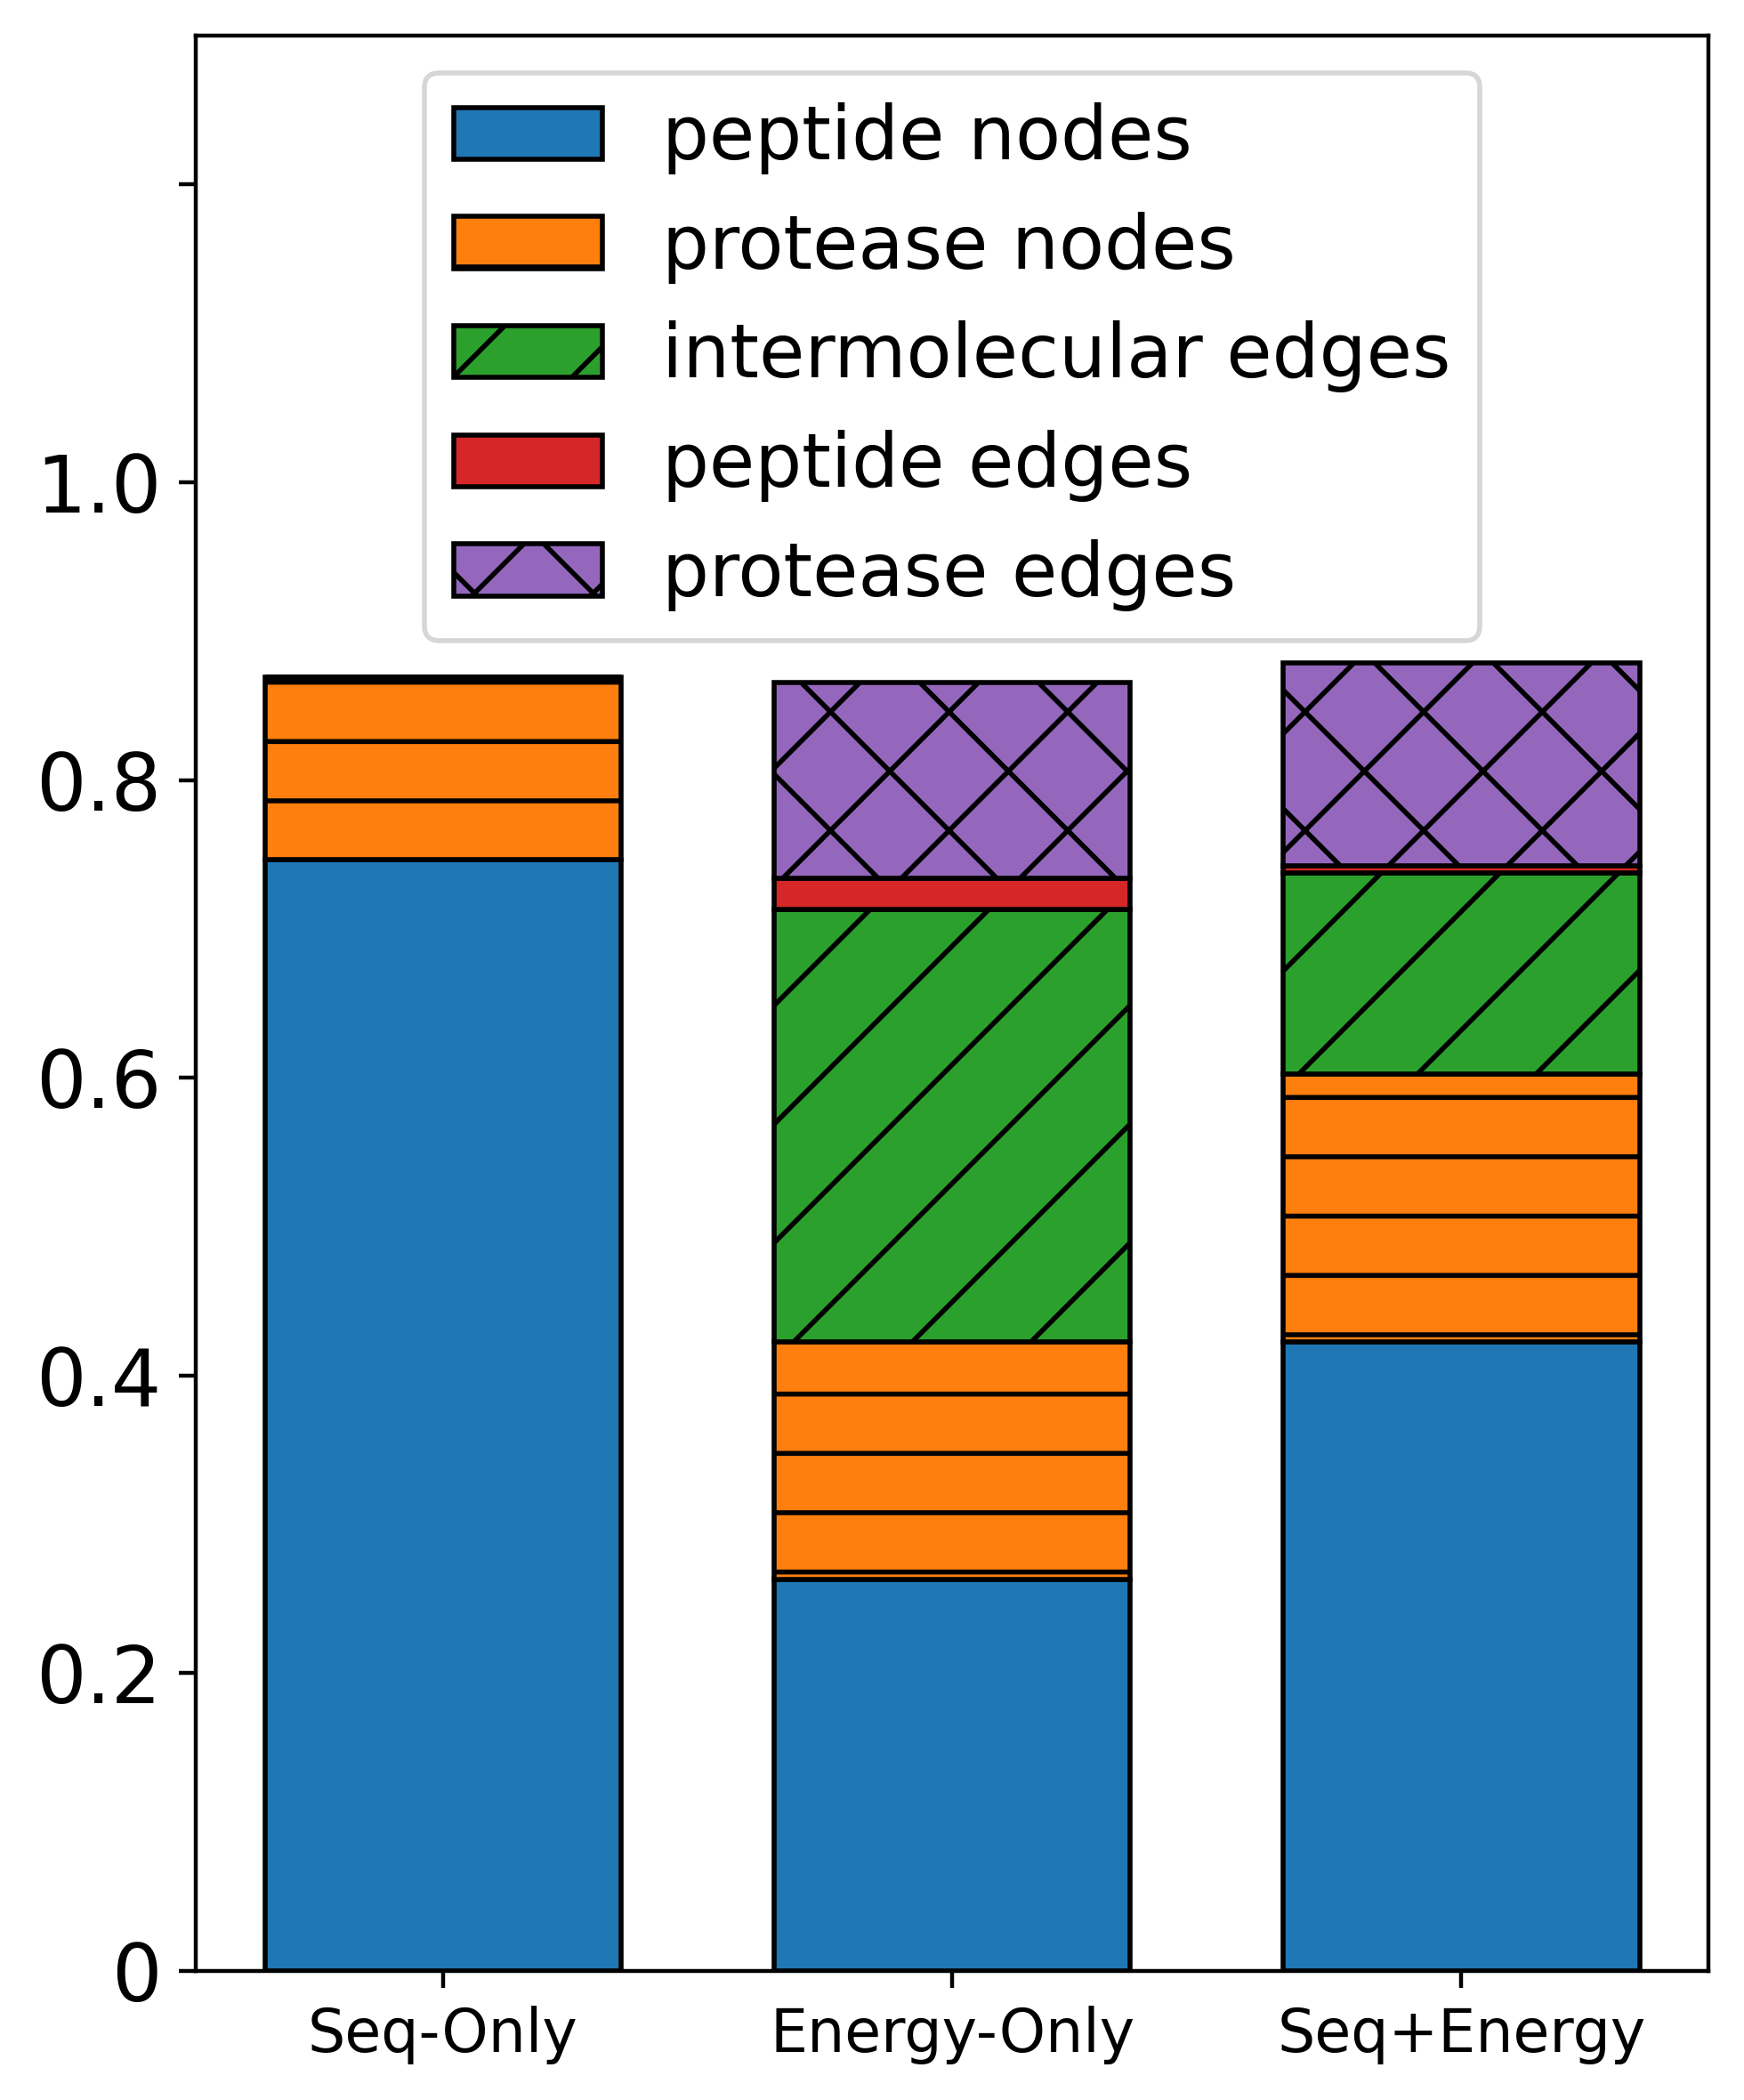

In [68]:
plt.style.use('default')
# font = {'serif' : 'Computer Modern',
#        'monospace' : 'Computer Modern',
#        'size' : 20}
# plt.rc('font',**font)
plt.rc('font', family='Roboto')
backsum = np.zeros(len(weight_cols))

barWidth = 0.7
r1 = np.arange(len(node_pep))

fig = plt.figure(figsize=(5,6))
plt.bar(r1, node_pep, color='tab:blue', width=barWidth, edgecolor='black', label='peptide nodes', capsize=4)
plt.bar(r1, node_pro, bottom=node_pep, color='tab:orange', hatch="-", width=barWidth, edgecolor='black', label='protease nodes', capsize=4)
plt.bar(r1, edge_int, bottom=node_pep + node_pro, color='tab:green', hatch="/", width=barWidth, edgecolor='black', label='intermolecular edges', capsize=4)
plt.bar(r1, edge_pep, bottom=node_pep + node_pro + edge_int, color='tab:red',width=barWidth, edgecolor='black', label='peptide edges', capsize=4)
plt.bar(r1, edge_pro, bottom=node_pep + node_pro + edge_int+ edge_pep, color='tab:purple', hatch="x", width=barWidth, edgecolor='black', label='protease edges', capsize=4)


# plt.gca().set_ylabel('Accuracy', fontsize=16)
plt.gca().set_ylim([0,1.3])
#ax.set_yticklabels([0.6,0.7,0.8,0.9,1.0])
plt.gca().set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
plt.gca().yaxis.set_tick_params(labelsize=16)
# ax.xaxis.set_minor_locator(ticker.FixedLocator([0,1]))
# ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['Sequence + Energies', 'Energies only']))
# ax.set_xticklabels(['Sequence + Energies', 'Energies only'], minor=True)
plt.gca().set_xticklabels(['Seq-Only','Energy-Only', "Seq+Energy", ], fontsize=12, ha='center', rotation_mode="anchor") 
#['Sequence + Energies', 'Energies only']
# plt.gca().set_xlim([-0.5,14.5]) #10.5
plt.gca().set_xticks(r1)

plt.legend(fontsize=15,loc=9,ncol=1)#,bbox_to_anchor=(1.5, 0.5))
#plt.title('Contributions of different component types', fontsize=14)
fig.set_dpi(400)
fig.tight_layout()
plt.savefig('figs/importance_TEV_20220722.png',bbox_inches='tight')
plt.show()

one explanation: node features are enough for combined models to distinguish cleaved and uncleaved

In [2]:
def scale_to_range(array_in, scale_min=0, scale_max=1, no_negative=True):
    """
    Scales values in an array to a given range. If no_negative, all negative
    values will be converted to zero.
    """
    array_out = np.array(array_in)
    
    if np.all(array_out==array_out[0]):
        return np.ones(len(array_out))*(scale_max-scale_min)
    #Eliminate negatives
    if no_negative:
        array_out[array_out < 0] = 0
    
    # Scale to [scale_min, scale_max] 
    array_out = (array_out - np.min(array_out)) / (np.max(array_out) - np.min(array_out)) * (scale_max - scale_min) + scale_min
    
    return array_out

In [9]:
def write_pymol_node_edge(df, category, outname, 
    pdb_file='protease_design/start_proteases/HCV.pdb', figname=None,
    pro_chain='A', pep_chain='B', peptide_start=1, cat_res=[72,96,154], p_len=7, pprime_len=4,
    sphere_min=0.1, sphere_max=0.3, 
    stick_min=0.2, stick_max=0.5, stick_edge_only=0.1,
    dash_min=0.1, dash_max=0.3, edge_threshold=0.25, 
    view=(0.48018771409988403, 0.7963227033615112, 0.3678136169910431, 
          0.32189586758613586, 0.23008576035499573, -0.9183899164199829, 
          -0.8159639239311218, 0.5593979954719543, -0.14584572613239288, 
          6.264075636863708e-05, -9.715929627418518e-05, -75.631103515625, 
          31.00339126586914, -14.977937698364258, 37.46116638183594,
          57.073768615722656, 94.35514068603516, -20.0)):
    """
    Write a PyMOL script to visualize node and edge importances. Input the node-edge weight
    table, a category (ex: 'WT_all'), and a file name to write to. 
    """
    # Initialize 
    script = []
    
    # Load starting PDB
    script.append('load {}'.format(pdb_file))
    
    # Make main selections
    script.append('select protease, chain {}'.format(pro_chain))
    script.append('select peptide, chain {}'.format(pep_chain))
    
    # Make catalytic selections
    for i in cat_res:
        script.append('select cat_{0}, protease and res {0}'.format(i))
        script.append('group catalytic, cat_{}'.format(i))
    
    # Make peptide node selections
    subst_res = peptide_start
    for i in range(p_len, 0, -1):
        script.append('select node_P{}, peptide and res {}'.format(i, subst_res))
        script.append('group pep_nodes, node_P{}'.format(i))
        subst_res += 1
    for i in range(1, pprime_len + 1):
        script.append('select node_P{}p, peptide and res {}'.format(i, subst_res))
        script.append('group pep_nodes, node_P{}p'.format(i))
        subst_res += 1
    
    # Set peptide node weights
    pep_nodes = df[(df['Type'] == 'node') & (df['Location'] == 'peptide')]
    pep_nodes['Feature'].replace("'",'p',inplace=True, regex=True)
    pep_nodes[category] = scale_to_range(pep_nodes[category], sphere_min, sphere_max)
    script.append('set sphere_scale, 0.1, peptide')
    for ind, row in pep_nodes.iterrows():
        script.append('set sphere_scale, {}, node_{}'.format(row[category], row['Feature']))
        
    # Make protease node selections
    prot_nodes = df[(df['Type'] == 'node') & (df['Location'] == 'protease')]
    prot_node_numbers = prot_nodes['Feature']
    script.append('select protease_nodes, none')
    for i in prot_node_numbers:
        script.append('select node_{0}, protease and res {0}'.format(i))
        script.append('group prot_nodes, node_{}'.format(i))
        script.append('select protease_nodes, protease_nodes or node_{}'.format(i))
    
    # Set protease node weights on a log scale
    contributing_prot_nodes = prot_nodes[prot_nodes[category] > 0]
    if contributing_prot_nodes.shape[0] !=0:
        contributing_node_list = contributing_prot_nodes['Feature']
        contributing_prot_nodes[category] = np.log10(contributing_prot_nodes[category])
        contributing_prot_nodes[category] += abs(min(contributing_prot_nodes[category]))
        contributing_prot_nodes[category] = \
            scale_to_range(contributing_prot_nodes[category], stick_min, stick_max)
        for ind, row in contributing_prot_nodes.iterrows():
            script.append('set stick_radius, {}, node_{}'.format(row[category], row['Feature']))
    else:
        contributing_node_list = []
    
        
    # Add edges on a log scale, only taking 
    contributing_edges = df[(df['Type'] == 'edge') & (df[category] > 0)]
    if contributing_edges.shape[0] != 0:
        contributing_edges[category] = np.log10(contributing_edges[category])
        contributing_edges[category] += abs(min(contributing_edges[category]))
        major_edges = contributing_edges[
            contributing_edges[category] >= edge_threshold * max(contributing_edges[category])]
        minor_edges = contributing_edges[
            contributing_edges[category] < edge_threshold * max(contributing_edges[category])]
        major_edges[category] = \
            scale_to_range(major_edges[category], dash_min, dash_max)
        minor_edges[category] = \
            scale_to_range(minor_edges[category], dash_min, dash_max)
        for edge_type, edge_df in {'major': major_edges, 'minor': minor_edges}.items():
            for ind, row in edge_df.iterrows():
                n1 = str(row['F1']).replace("'", "p")
                n2 = str(row['F2']).replace("'", "p")
                script.append('distance {0}_{1}, node_{0} and n. CA, node_{1} and n. CA'.format(n1, n2))
                script.append('set dash_radius, {2}, {0}_{1}'.format(n1, n2, row[category]))
                script.append('group {2}_edges, {0}_{1}'.format(n1, n2, edge_type))
            
        # Set sidechains for nodes with edges
            # Collect list of nodes participating in major edges
        participating_nodes = []
        participating_nodes += list(major_edges[major_edges['Location'] == 'protease']['F1'])
        participating_nodes += list(major_edges[major_edges['Location'] == 'protease']['F2'])
        participating_nodes += list(major_edges[major_edges['Location'] == 'intermolecular']['F2'])
        # Exclude nodes that already have a weight and are catalytic residues
        participating_nodes = list(set(participating_nodes) - set(contributing_node_list) - set([str(x) for x in cat_res])) #[i for i in participating_nodes if i not in contributing_node_list]
        # Setting weights
        for node in participating_nodes:
                script.append('set stick_radius, {}, node_{}'.format(stick_edge_only, node))
    else:
        participating_nodes = []
    
    # Display and color structure
    script.append('hide everything')
    script.append('show sticks, peptide and n. CA+CB')
    script.append('show spheres, peptide and n. CB')
    # script.append('set cartoon_transparency, 0.5, peptide')
    # script.append('set sphere_transparency, 0.3, peptide')
    # script.append('set stick_transparency, 0.8, peptide')
    # script.append('set dash_transparency, 0.2')
    script.append('show sticks, catalytic')
    if len(contributing_node_list) != 0:
        script.append('show sticks, {}'.format(
        ' or '.join(['node_{}'.format(i) for i in contributing_node_list])))
    if len(participating_nodes) != 0:
        script.append('show sticks, {}'.format(
        ' or '.join(['node_{}'.format(i) for i in participating_nodes])))
    script.append('hide everything, e. H')
    script.append('hide sticks, n. N+C')
    script.append('hide lines, n. N+C')
    script.append('show surface')
    script.append('show cartoon, peptide')
    script.append('set transparency, 0.7')
    script.append('set cartoon_transparency, 0.4')
    script.append('color cyan, peptide')
    script.append('color magenta, catalytic')
    #script.append('color violet, prot_nodes')
    for node in participating_nodes:
            script.append('color violet, node_{} '.format(node))
    for node in contributing_node_list:
        script.append('color orange, node_{}'.format(node))
    # script.append('color gray40, protease and not protease_nodes')
    script.append('util.cnc')
    script.append('set surface_color, gray50')
    # Display edges
    script.append('hide labels, *_edges ')
    script.append('set dash_gap, 0.5, *_edges')
    if contributing_edges.shape[0] != 0:
        # script.append('color green, major_edges')
        # script.append('color palegreen, minor_edges')
        for ind, row in major_edges[major_edges['Location'] == 'protease'].iterrows():
            n1 = str(row['F1']).replace("'", "p")
            n2 = str(row['F2']).replace("'", "p")
            script.append('color green, {0}_{1}'.format(n1, n2))
        for ind, row in major_edges[major_edges['Location'] == 'intermolecular'].iterrows():
            n1 = str(row['F1']).replace("'", "p")
            n2 = str(row['F2']).replace("'", "p")
            script.append('color tvyellow, {0}_{1}'.format(n1, n2))
        for ind, row in major_edges[major_edges['Location'] == 'peptide'].iterrows():
            n1 = str(row['F1']).replace("'", "p")
            n2 = str(row['F2']).replace("'", "p")
            script.append('color blue, {0}_{1}'.format(n1, n2))
        script.append('show dashes, major_edges')
    
    script.append('set cartoon_rect_width, 0.1')
    script.append('set cartoon_rect_length, 0.9')
    script.append('set stick_radius, 0.1, peptide')
    script.append('set cartoon_loop_radius, 0.1')
    script.append('set sphere_transparency, 0.4')
    script.append('set stick_transparency, 0.4, peptide')
    
    # Set view
    script.append('v = {}'.format(view))
    script.append('cmd.set_view(v)')
    script.append('bg_color white')
    # Render and save figure
    if figname:
        script.append('png {}, width=1000, height=800, dpi=1200'.format(figname))
    
    # Write file
    with open(outname, 'w') as w:
        w.write('\n'.join(script))
        
    return            

In [11]:
for data in ['WT','A171T','D183A','Triple','all']:
    for feature in ['complete','seq','energy']:
        print(data,feature)
        if data == 'WT' or 'all':
            pdb = 'HCV.pdb'
        elif data == 'A171T':
            pdb = 'hcv_a171t.pdb'
        elif data == 'D183A':
            pdb = 'hcv_d183a.pdb'
        elif data == 'Triple':
            pdb = 'hcv_triple.pdb'
        write_pymol_node_edge(df, 'HCV_' + data + '_' + feature, 'figs/HCV_pse/' + 'HCV_' + data + '_' + feature + '_new.pml', pdb_file = 'HCV.pdb', 
                      cat_res = [72, 96, 154], peptide_start= 1, pprime_len=4, figname='HCV_' + data + '_' + feature + '.png',
                      view=((0.596664547920227, 0.21827423572540283, 0.7722093462944031, 0.14030160009860992, 0.9190970063209534, -0.3682032525539398, -0.7900993227958679, 0.32803815603256226, 0.5177739858627319, 9.148754179477692e-05, -0.0005362518131732941, -74.54239654541016, 36.59576416015625, -24.78789520263672, 33.90799331665039, 38.98846435546875, 108.88653564453125, -20.0)))

WT complete
WT seq
WT energy
A171T complete
A171T seq
A171T energy
D183A complete
D183A seq
D183A energy
Triple complete
Triple seq
Triple energy
all complete
all seq
all energy


/home/cplu/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-9-8fc62b057119>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pep_nodes[category] = scale_to_range(pep_nodes[category], sphere_min, sphere_max)
<ipython-input-9-8fc62b057119>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs